# CWE Analysis
The purpose of this pipeline is to collect metadata about the CWE. In particular view CWE-1003 as it's contains the weaknesses the NVD use for labeling. However we may also take a look at view CWE-1000 for completeness. 

In [3]:
import requests
import json

def req_CWE(url, jfile = None, printj = True) :
    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/115.0'
    }
    try:
        # Make the request
        reply = requests.get(url, headers=headers, timeout=100)
        reply.raise_for_status()
        jreply = reply.json()

        if not printj :
            return jreply
        # Write the JSON response to a file
        if jfile is None : 
            print(json.dumps(jreply, indent=4))
        else :
            with open('tmp/' + jfile, 'w') as file:
                json.dump(jreply, file, indent=4)  # Write JSON data to the file with indentation
            print("Data successfully written to 'tmp/" + jfile + "'")
        return jreply
    except Exception as exp:
        # Handle exceptions and write error details to the file
        if jfile is None  :
            print(f"Exception -> {exp}")
            print(f"Request status -> {reply.status_code}")
        else :
            with open('tmp/' + jfile, 'w') as file:
                error_message = {
                    "error": str(exp),
                    "status_code": reply.status_code if 'reply' in locals() else None
                }
                json.dump(error_message, file, indent=4)
            print(f"Exception occurred. Details written to 'tmp/" + jfile + "'")

Random tests to get a view into the CWE API and database.

In [ ]:

# temporary tests
url_view1003 = 'https://cwe-api.mitre.org/api/v1/cwe/view/1003'
url_view1003_des = 'https://cwe-api.mitre.org/api/v1/cwe/74/descendants?view=1003'
url_view1003_children = 'https://cwe-api.mitre.org/api/v1/cwe/74/children?view=1003'
url_CWE_20_74_inf = 'https://cwe-api.mitre.org/api/v1/cwe/weakness/20,74?view=1003'
#url_CWE_all1003_inf = 'https://cwe-api.mitre.org/api/v1/cwe/weakness?view=1003'
url_leaf1284 = 'https://cwe-api.mitre.org/api/v1/cwe/1284/children?view=1003'
print(len(req_CWE(url_view1003, 'view_CWE-1003.json')['Views'][0]['Members']))
req_CWE(url_view1003_des, 'view_CWE-1003_desc_CWE-74.json')
req_CWE(url_view1003_children, 'view_CWE-1003_children_CWE-74.json')
req_CWE(url_CWE_20_74_inf, 'CWE-20,74_weakness.json')
#req_CWE(url_CWE_all1003_inf, 'CWE-1003_weakness.json')
req_CWE(url_leaf1284, 'url_leaf1284.json')

Extracting relevant views using the CWE API

In [4]:
import pickle
import time
import sys

#sys.setrecursionlimit(2000)
def rec_expand(view, cweID, id_list) : 
    childrenURL = 'https://cwe-api.mitre.org/api/v1/cwe/' + cweID + '/children?view=' + view
    childrenj = req_CWE(childrenURL, printj=False)
    for child in childrenj : 
        headID = child['ID']
        if headID in id_list :  
            continue
        id_list.append(headID)
        id_list = rec_expand(view, headID, id_list)
    
    return id_list

def chunkl(lst, ch_size) :
    chunks = []
    for i in range(0, len(lst), ch_size) : 
        chunks.append(lst[i:i + ch_size])
    return chunks

def get_weaknesses_from_view(view, expand = False, save=False) :
    viewURL = 'https://cwe-api.mitre.org/api/v1/cwe/view/' + view
    weaknessesURL_header = 'https://cwe-api.mitre.org/api/v1/cwe/weakness/'
    id_list = []
    jview = req_CWE(viewURL, printj=False)
    for member in jview['Views'][0]['Members'] :
        headID = member['CweID']
        if headID not in id_list :  
            id_list.append(headID)
        if expand : 
            id_list = rec_expand(view, headID, id_list)
        #time.sleep(1)
    
    ch_size = 200
    id_chunks = chunkl(id_list, ch_size)
    jview_complete = {"Weaknesses": []}
    for id_chunk in id_chunks : 
        weaknessesURL = weaknessesURL_header + ",".join(id_chunk)
        jresp = req_CWE(weaknessesURL, printj=False)
        
        if not isinstance(jresp, dict):
            raise ValueError(f"Expected JSON object (dict), but got {type(jresp)}")
        if "Weaknesses" not in jresp:
            raise KeyError(f"Missing 'Weaknesses' key in response: {jresp}")

        jview_complete["Weaknesses"].extend(jresp["Weaknesses"])

        #debug print
        print("resulting API request " + weaknessesURL)
    
    print("Number of weaknesses extracted:\t", len(id_list))
    
    #debug print
    print ("Duplicate ID's?", len(id_list) > len(set(id_list)))
    
    if save :
        fsave_name = "view_CWE-" + view + ("_all_weaknesses" if expand else "_head_weaknesses") + ".json"
        with open('tmp/' + fsave_name, 'w') as file:
            json.dump(jview_complete, file, indent=4)  # Write JSON data to the file with indentation
        print("Data successfully written to 'tmp/" + fsave_name + "'")
    return jview_complete


In [ ]:

jview1003_complete = get_weaknesses_from_view('1003', True, True)

# Save jview1003_complete using pickle
pickle_file = 'tmp/jview1003_complete.pkl'
with open(pickle_file, 'wb') as file:
    pickle.dump(jview1003_complete, file)
print(f"Data successfully saved to '{pickle_file}' using pickle.")

resulting API request https://cwe-api.mitre.org/api/v1/cwe/weakness/20,1284,129,74,1236,77,78,79,88,89,91,917,94,116,838,119,120,125,787,824,200,203,209,532,269,287,290,294,295,306,307,521,522,640,798,311,312,319,326,327,916,330,331,335,338,345,346,347,352,354
resulting API request https://cwe-api.mitre.org/api/v1/cwe/weakness/924,362,367,400,770,920,404,401,459,763,772,407,1333,436,444,610,1021,384,601,611,918,662,667,665,1188,908,909,668,134,426,427,428,552,669,212,434,494,565,829,670,617,672,415,416,613,674,776,682,131,190
resulting API request https://cwe-api.mitre.org/api/v1/cwe/weakness/191,193,369,697,704,681,843,706,178,22,59,732,276,281,754,252,273,476,755,834,835,862,425,863,639,913,1321,470,502,922
Number of weaknesses extracted:	 130
Duplicate ID's? False
Data successfully written to 'tmp/view_CWE-1003_all_weaknesses.json'
Data successfully saved to 'tmp/jview1003_complete.pkl' using pickle.


In [38]:

import pandas as pd
    
def rec_expand_path(cweID : str, weaknesses, path_df) :
    if not path_df[path_df['ID'] == cweID].empty:
        return path_df
    rw_list = weaknesses.loc[weaknesses['ID'] == cweID, 'RelatedWeaknesses'].values
    if len(rw_list) == 0 or len(rw_list[0]) == 0 or not isinstance(rw_list[0], list):
        new_row = pd.DataFrame([{'ID': cweID, 'NumPaths': 1, 'Paths': [[cweID]]}])
        path_df = pd.concat([path_df, new_row], ignore_index=True)
        return path_df
    
    rw = rw_list[0]

    if not rw:  
        new_row = pd.DataFrame([{'ID': cweID, 'NumPaths': 1, 'Paths': [[cweID]]}])
        path_df = pd.concat([path_df, new_row], ignore_index=True)
        return path_df

    paths = []  
    num_paths = 0
    for w in rw :
        cid = w['CweID']
        path_df = rec_expand_path(cid, weaknesses, path_df)
        num_paths += path_df[path_df['ID'] == cid].NumPaths.values[0]
        paths += [p + [cweID] for p in path_df[path_df['ID'] == cid].Paths.values[0]]
    
    new_row = pd.DataFrame([{'ID': cweID, 'NumPaths': num_paths, 'Paths': paths}])
    path_df = pd.concat([path_df, new_row], ignore_index=True)
    return path_df

def get_paths(view, df_weaknesses, combine = False) :
    df_weak = df_weaknesses.copy()
    df_weak['RelatedWeaknesses'] = df_weak['RelatedWeaknesses'].apply(
        lambda weaknesses: [w for w in weaknesses if w['ViewID'] == view and w['Nature'] == 'ChildOf'] 
        if isinstance(weaknesses, list) else [])
    
    #display(df_weaknesses)
    path_df = pd.DataFrame(columns=['ID', 'NumPaths', 'Paths'])
    for cweID in df_weak['ID'] :
        path_df = rec_expand_path(cweID, df_weak, path_df) 
    
    path_df['ID'] = path_df['ID'].astype(str)
    df_weak['ID'] = df_weak['ID'].astype(str)
    if combine : 
        return pd.merge(df_weak, path_df, on='ID')
    return path_df


In [39]:
import pickle
pickle_file = 'tmp/jview1003_complete.pkl'
with open(pickle_file, 'rb') as file:
    jview1003_complete = pickle.load(file)
# Now you can use jview1003_complete as a Python object
#print(json.dumps(jview1003_complete, indent=4))
df_view1003_complete = pd.DataFrame(pd.json_normalize(jview1003_complete["Weaknesses"], sep='_'))
#display(df_view1003_complete[:5])
#display(df_view1003_complete[['ID', 'RelatedWeaknesses']])
get_paths('1003', df_view1003_complete, True)
#display(df_view1003_complete[:5])
#display(df_view1003_complete[df_view1003_complete['ID'] == '20']['S'])


,ID,Name,Abstraction,Structure,Status,Description,ExtendedDescription,LikelihoodOfExploit,RelatedWeaknesses,ApplicablePlatforms,...,MappingNotes_Reasons,MappingNotes_Suggestions,WeaknessOrdinalities,AlternateTerms,AffectedResources,Diagram,FunctionalAreas,BackgroundDetails,NumPaths,Paths
0,20,Improper Input Validation,Class,Simple,Stable,"The product receives input or data, but it doe...",\n\nInput validation is a frequently-used tech...,High,[],"[{'Type': 'Language', 'Class': 'Not Language-S...",...,[Frequent Misuse],"[{'CweID': '1284', 'Comment': 'Specified Quant...",NaN,NaN,NaN,NaN,NaN,NaN,1,[[20]]
1,1284,Improper Validation of Specified Quantity in I...,Base,Simple,Incomplete,The product receives input that is expected to...,"\n\nSpecified quantities include size, length,...",NaN,"[{'Nature': 'ChildOf', 'CweID': '20', 'ViewID'...","[{'Type': 'Language', 'Class': 'Not Language-S...",...,[Acceptable-Use],NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"[[20, 1284]]"
2,129,Improper Validation of Array Index,Variant,Simple,Draft,The product uses untrusted input when calculat...,NaN,High,"[{'Nature': 'ChildOf', 'CweID': '20', 'ViewID'...","[{'Type': 'Language', 'Name': 'C', 'Prevalence...",...,[Acceptable-Use],NaN,"[{'Ordinality': 'Resultant', 'Description': 'T...","[{'Term': 'out-of-bounds array index'}, {'Term...",[Memory],NaN,NaN,NaN,1,"[[20, 129]]"
3,74,Improper Neutralization of Special Elements in...,Class,Simple,Incomplete,The product constructs all or part of a comman...,Software or other automated logic has certain ...,High,[],"[{'Type': 'Language', 'Class': 'Not Language-S...",...,"[Frequent Misuse, Abstraction]",NaN,[{'Ordinality': 'Primary'}],NaN,NaN,NaN,NaN,NaN,1,[[74]]
4,1236,Improper Neutralization of Formula Elements in...,Base,Simple,Incomplete,The product saves user-provided information in...,User-provided data is often saved to tradition...,NaN,"[{'Nature': 'ChildOf', 'CweID': '74', 'ViewID'...","[{'Type': 'Language', 'Class': 'Not Language-S...",...,[Acceptable-Use],NaN,NaN,"[{'Term': 'CSV Injection'}, {'Term': 'Formula ...",NaN,NaN,NaN,NaN,1,"[[74, 1236]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,913,Improper Control of Dynamically-Managed Code R...,Class,Simple,Incomplete,The product does not properly restrict reading...,Many languages offer powerful features that al...,NaN,[],NaN,...,[Abstraction],NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,[[913]]
126,1321,Improperly Controlled Modification of Object P...,Variant,Simple,Incomplete,The product receives input from an upstream co...,\n\nBy adding or modifying attributes of an ob...,NaN,"[{'Nature': 'ChildOf', 'CweID': '913', 'ViewID...","[{'Type': 'Language', 'Name': 'JavaScript', 'P...",...,[Acceptable-Use],NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"[[913, 1321]]"
127,470,Use of Externally-Controlled Input to Select C...,Base,Simple,Draft,The product uses external input with reflectio...,If the product uses external inputs to determi...,NaN,"[{'Nature': 'ChildOf', 'CweID': '913', 'ViewID...","[{'Type': 'Language', 'Name': 'Java', 'Prevale...",...,[Acceptable-Use],NaN,NaN,[{'Term': 'Reflection Injection'}],NaN,NaN,NaN,NaN,1,"[[913, 470]]"
128,502,Deserialization of Untrusted Data,Base,Simple,Draft,The product deserializes untrusted data withou...,NaN,Medium,"[{'Nature': 'ChildOf', 'CweID': '913', 'ViewID...","[{'Type': 'Language', 'Name': 'Java', 'Prevale...",...,[Acceptable-Use],NaN,NaN,"[{'Term': 'Marshaling, Unmarshaling', 'Descrip...",NaN,/data/images/CWE-502-Diagram.png,NaN,[Serialization and deserialization refer to th...,1,"[[913, 502]]"


In [40]:
from datasets import Dataset 
df_view1003_complete = pd.DataFrame(pd.json_normalize(jview1003_complete["Weaknesses"], sep='_'))
df_view1003_complete = get_paths('1003', df_view1003_complete, True)
ds_view1003_complete = Dataset.from_pandas(df_view1003_complete)
ds_view1003_complete.push_to_hub('Eathus/cwe_view1003_raw_list')

Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/Eathus/cwe_view1003_raw_list/commit/3fbb46596d85118ecb9179d9081b105576cbf97b', commit_message='Upload dataset', commit_description='', oid='3fbb46596d85118ecb9179d9081b105576cbf97b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Eathus/cwe_view1003_raw_list', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Eathus/cwe_view1003_raw_list'), pr_revision=None, pr_num=None)

## View CWE-1003

In [42]:

# Now you can use jview1003_complete as a Python object
#print(json.dumps(jview1003_complete, indent=4))
df_view1003_complete = pd.DataFrame(pd.json_normalize(jview1003_complete["Weaknesses"], sep='_'))
#display(df_view1003_complete[:5])
#display(df_view1003_complete[['ID', 'RelatedWeaknesses']])
df_view1003_complete_paths = get_paths('1003', df_view1003_complete, True)
display(df_view1003_complete_paths)
#display(*df_view1003_complete['RelatedWeaknesses'])
#display(df_view1003_complete[:5])
#display(df_view1003_complete[df_view1003_complete['ID'] == '20']['S'])


,ID,Name,Abstraction,Structure,Status,Description,ExtendedDescription,LikelihoodOfExploit,RelatedWeaknesses,ApplicablePlatforms,...,MappingNotes_Reasons,MappingNotes_Suggestions,WeaknessOrdinalities,AlternateTerms,AffectedResources,Diagram,FunctionalAreas,BackgroundDetails,NumPaths,Paths
0,20,Improper Input Validation,Class,Simple,Stable,"The product receives input or data, but it doe...",\n\nInput validation is a frequently-used tech...,High,[],"[{'Type': 'Language', 'Class': 'Not Language-S...",...,[Frequent Misuse],"[{'CweID': '1284', 'Comment': 'Specified Quant...",NaN,NaN,NaN,NaN,NaN,NaN,1,[[20]]
1,1284,Improper Validation of Specified Quantity in I...,Base,Simple,Incomplete,The product receives input that is expected to...,"\n\nSpecified quantities include size, length,...",NaN,"[{'Nature': 'ChildOf', 'CweID': '20', 'ViewID'...","[{'Type': 'Language', 'Class': 'Not Language-S...",...,[Acceptable-Use],NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"[[20, 1284]]"
2,129,Improper Validation of Array Index,Variant,Simple,Draft,The product uses untrusted input when calculat...,NaN,High,"[{'Nature': 'ChildOf', 'CweID': '20', 'ViewID'...","[{'Type': 'Language', 'Name': 'C', 'Prevalence...",...,[Acceptable-Use],NaN,"[{'Ordinality': 'Resultant', 'Description': 'T...","[{'Term': 'out-of-bounds array index'}, {'Term...",[Memory],NaN,NaN,NaN,1,"[[20, 129]]"
3,74,Improper Neutralization of Special Elements in...,Class,Simple,Incomplete,The product constructs all or part of a comman...,Software or other automated logic has certain ...,High,[],"[{'Type': 'Language', 'Class': 'Not Language-S...",...,"[Frequent Misuse, Abstraction]",NaN,[{'Ordinality': 'Primary'}],NaN,NaN,NaN,NaN,NaN,1,[[74]]
4,1236,Improper Neutralization of Formula Elements in...,Base,Simple,Incomplete,The product saves user-provided information in...,User-provided data is often saved to tradition...,NaN,"[{'Nature': 'ChildOf', 'CweID': '74', 'ViewID'...","[{'Type': 'Language', 'Class': 'Not Language-S...",...,[Acceptable-Use],NaN,NaN,"[{'Term': 'CSV Injection'}, {'Term': 'Formula ...",NaN,NaN,NaN,NaN,1,"[[74, 1236]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,913,Improper Control of Dynamically-Managed Code R...,Class,Simple,Incomplete,The product does not properly restrict reading...,Many languages offer powerful features that al...,NaN,[],NaN,...,[Abstraction],NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,[[913]]
126,1321,Improperly Controlled Modification of Object P...,Variant,Simple,Incomplete,The product receives input from an upstream co...,\n\nBy adding or modifying attributes of an ob...,NaN,"[{'Nature': 'ChildOf', 'CweID': '913', 'ViewID...","[{'Type': 'Language', 'Name': 'JavaScript', 'P...",...,[Acceptable-Use],NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"[[913, 1321]]"
127,470,Use of Externally-Controlled Input to Select C...,Base,Simple,Draft,The product uses external input with reflectio...,If the product uses external inputs to determi...,NaN,"[{'Nature': 'ChildOf', 'CweID': '913', 'ViewID...","[{'Type': 'Language', 'Name': 'Java', 'Prevale...",...,[Acceptable-Use],NaN,NaN,[{'Term': 'Reflection Injection'}],NaN,NaN,NaN,NaN,1,"[[913, 470]]"
128,502,Deserialization of Untrusted Data,Base,Simple,Draft,The product deserializes untrusted data withou...,NaN,Medium,"[{'Nature': 'ChildOf', 'CweID': '913', 'ViewID...","[{'Type': 'Language', 'Name': 'Java', 'Prevale...",...,[Acceptable-Use],NaN,NaN,"[{'Term': 'Marshaling, Unmarshaling', 'Descrip...",NaN,/data/images/CWE-502-Diagram.png,NaN,[Serialization and deserialization refer to th...,1,"[[913, 502]]"


In [5]:
i = 1
while len(df_view1003_complete_paths[df_view1003_complete_paths['NumPaths'] >= i]) != 0 :
    print("All CWEs with", i, "path(s)")
    paths = df_view1003_complete_paths[df_view1003_complete_paths['NumPaths'] == i]
    display(paths)
    print(len(paths))
    i += 1

All CWEs with 1 path(s)


,ID,NumPaths,Paths
0,20,1,[[20]]
1,1284,1,"[[20, 1284]]"
2,129,1,"[[20, 129]]"
3,74,1,[[74]]
4,1236,1,"[[74, 1236]]"
...,...,...,...
125,913,1,[[913]]
126,1321,1,"[[913, 1321]]"
127,470,1,"[[913, 470]]"
128,502,1,"[[913, 502]]"


130


,Nature,Proportion
0,ChildOf,1.0


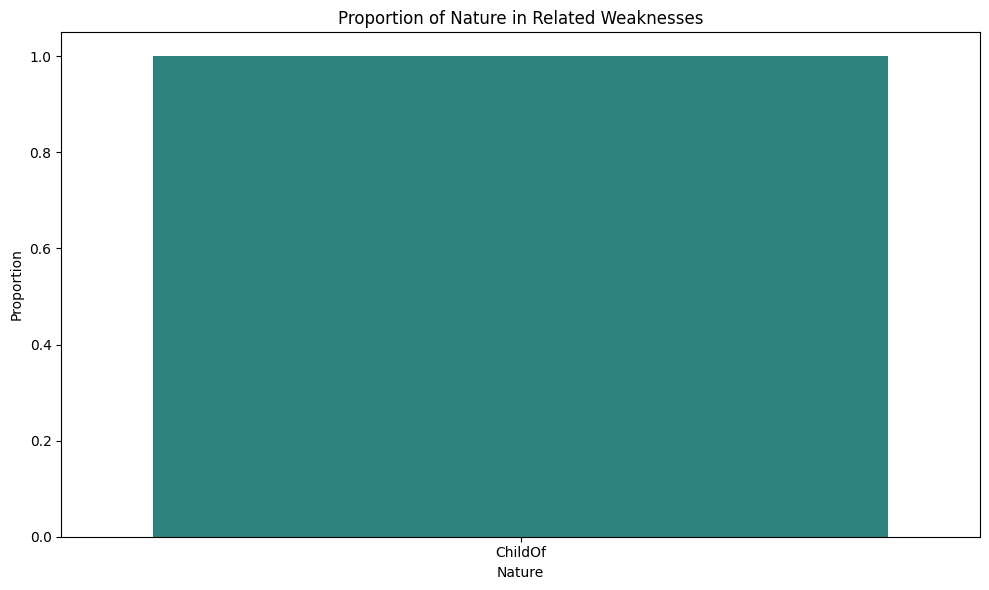

Nature
ChildOf    1.0
Name: proportion, dtype: float64

In [8]:

import seaborn as sns
import matplotlib.pyplot as plt

def rwn_distribution(jview, view, normalize=False, plot = True) :
    df = pd.DataFrame(pd.json_normalize(jview["Weaknesses"], sep='_'))
    df['RelatedWeaknesses'] = df['RelatedWeaknesses'].apply(
        lambda weaknesses: [w for w in weaknesses if w['ViewID'] == view] 
        if isinstance(weaknesses, list) else [])

    #display(*df['RelatedWeaknesses'])
    df_rw = pd.json_normalize(df['RelatedWeaknesses'].explode().dropna())
    data = df_rw['Nature'].value_counts(normalize=normalize)

    if plot :
        data_df = data.reset_index()
        data_df.columns = ['Nature', ('Proportion' if normalize else 'Count')]
        display(data_df)
        # Plotting
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Nature', 
                    y=('Proportion' if normalize else 'Count'), 
                    hue='Nature',
                    data=data_df, palette='viridis')

        # Add labels and title
        plt.title('Proportion of Nature in Related Weaknesses')
        
        # Show the plot
        plt.tight_layout()
        plt.show()

    return data

rwn_distribution(jview1003_complete, '1003', True)







,Usage,Count
0,Allowed,85
1,Allowed-with-Review,27
2,Discouraged,18


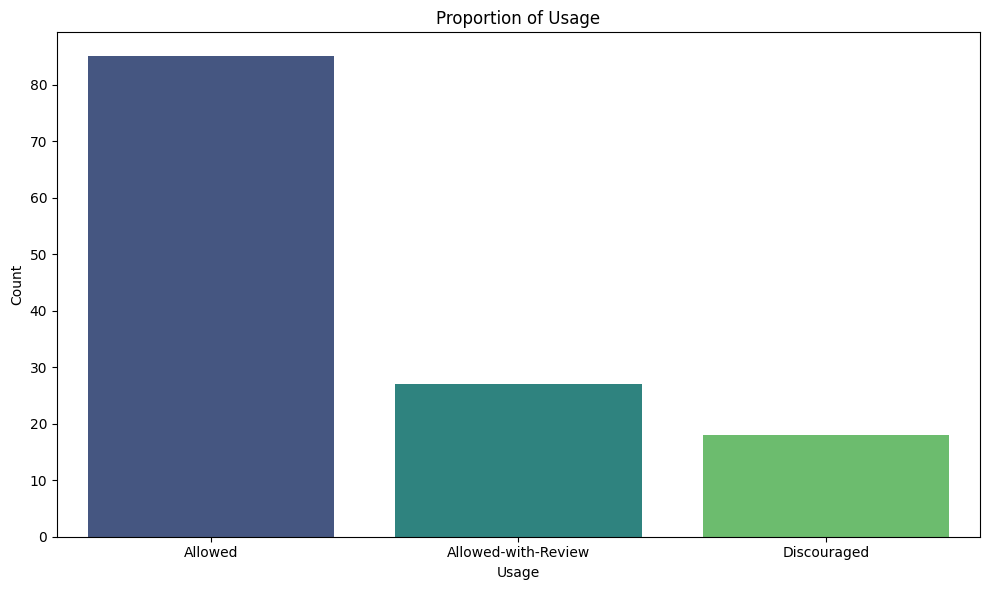

MappingNotes_Usage
Allowed                85
Allowed-with-Review    27
Discouraged            18
Name: count, dtype: int64

In [9]:
def usage_distribution(jview, plot = True, normalize = False) :
    df = pd.DataFrame(pd.json_normalize(jview["Weaknesses"], sep='_'))
    data = df['MappingNotes_Usage'].value_counts(normalize=normalize)
    if plot :
        data_df = data.reset_index()
        data_df.columns = ['Usage', ('Proportion' if normalize else 'Count')]
        display(data_df)
        # Plotting
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Usage', 
                    y=('Proportion' if normalize else 'Count'), 
                    hue='Usage',
                    data=data_df, palette='viridis')

        # Add labels and title
        plt.title('Proportion of Usage')
        
        # Show the plot
        plt.tight_layout()
        plt.show()

    return data

    
usage_distribution(jview1003_complete)

In [28]:
def view_max_depth(jview, view) :
    df = pd.DataFrame(pd.json_normalize(jview["Weaknesses"], sep='_'))
    df_paths = get_paths(view, df)
    path_array = df_paths['Paths'].values
    path_depths = [len(x) for x in path_array]
    return max(path_depths)



view_max_depth(jview1003_complete, '1003')


1

## View CWE-1000

In [ ]:
jview1000_complete = get_weaknesses_from_view('1000', True, True)

# Save jview1003_complete using pickle

pickle1000_file = 'tmp/jview1000_complete.pkl'
with open(pickle1000_file, 'wb') as file:
    pickle.dump(jview1000_complete, file)
print(f"Data successfully saved to '{pickle1000_file}' using pickle.")

resulting API request https://cwe-api.mitre.org/api/v1/cwe/weakness/284,1191,1220,1222,1224,1231,1233,1242,1252,1257,1259,1260,1262,1263,1243,1267,1268,1270,1274,1276,1280,1283,1290,1292,1294,1302,1296,1304,1311,1312,1313,1315,1316,1317,1320,1323,1334,269,250,266,1022,520,556,9,267,623,268,270,271,272,273,274,648,282,283,708,285,1230,202,612,1256,1297,1328,552,219,433,220,527,528,529,530,539,553,732,1004,276,277,278,279,281,766,862,1314,425,638,424,939,863,1244,551,639,566,647,804,942,926,927,286,842,287,1390,1391,1392,1393,1394,521,258,798,259,321,262,263,289,290,291,293,350,294,301,302,303,304,305,307,308,309,522,256,257,260,13,555,261,523,549,593,603,620,640,836,295,296,297,298,299,370,599,306,288,1299,322,645,346,1385,940,925,749,618,782,923,1275,300,419,420,421,422,941,435,1038,1037,733,14,188,198,436,113,115,437,444,626,650,86,439,664,118,119,120,785,125,126,127,466,786,124,787,121,122,123,788,805
resulting API request https://cwe-api.mitre.org/api/v1/cwe/weakness/806,822,823,824

In [6]:
import json

with open("tmp/view_CWE-1000_all_weaknesses.json", "r") as f:
    json_data = json.load(f)  # Load 

with open("tmp/jview1000_complete.pkl", "wb") as f:
    pickle.dump(json_data, f)  # Save JSON object as a pickle file

In [41]:

import pickle
import pandas
pickle_file = 'tmp/jview1000_complete.pkl'
with open(pickle_file, 'rb') as file:
    jview1000_complete = pickle.load(file)

df_view1000_complete = pd.DataFrame(pd.json_normalize(jview1000_complete["Weaknesses"], sep='_'))

df_view1000_path_info = get_paths('1000', df_view1000_complete)
#display(*df_view1000_complete['RelatedWeaknesses'])

In [43]:
from datasets import Dataset 
df_view1000_complete = pd.DataFrame(pd.json_normalize(jview1000_complete["Weaknesses"], sep='_'))
df_view1000_complete = get_paths('1000', df_view1000_complete, True)
ds_view1000_complete = Dataset.from_pandas(df_view1000_complete)
ds_view1000_complete.push_to_hub('Eathus/cwe_view1000_raw_list')

Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/Eathus/cwe_view1000_raw_list/commit/a002fb54778191382a7a755849890614031801b0', commit_message='Upload dataset', commit_description='', oid='a002fb54778191382a7a755849890614031801b0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Eathus/cwe_view1000_raw_list', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Eathus/cwe_view1000_raw_list'), pr_revision=None, pr_num=None)

In [8]:
i = 1
while len(df_view1000_complete[df_view1000_complete['NumPaths'] >= i]) != 0 :
    print("All CWEs with", i, "path(s)")
    paths = df_view1000_complete[df_view1000_complete['NumPaths'] == i]
    display(paths)
    print(len(paths))
    i += 1

print(*df_view1000_complete[df_view1000_complete['ID'] == '425']['Paths'])

All CWEs with 1 path(s)


,ID,NumPaths,Paths
0,284,1,[[284]]
1,1191,1,"[[284, 1191]]"
2,1220,1,"[[284, 1220]]"
3,1222,1,"[[284, 1220, 1222]]"
4,1224,1,"[[284, 1224]]"
...,...,...,...
935,1102,1,"[[710, 758, 1102]]"
936,1103,1,"[[710, 758, 1103]]"
937,474,1,"[[710, 758, 474]]"
938,589,1,"[[710, 758, 474, 589]]"


676
All CWEs with 2 path(s)


,ID,NumPaths,Paths
8,662,2,"[[664, 662], [691, 662]]"
9,667,2,"[[664, 662, 667], [691, 662, 667]]"
25,1280,2,"[[691, 696, 1280], [284, 1280]]"
45,250,2,"[[284, 269, 250], [710, 657, 250]]"
59,273,2,"[[703, 754, 273], [284, 269, 271, 273]]"
...,...,...,...
773,694,2,"[[707, 74, 99, 694], [710, 573, 694]]"
811,643,2,"[[707, 74, 943, 643], [707, 74, 91, 643]]"
812,652,2,"[[707, 74, 943, 652], [707, 74, 91, 652]]"
817,462,2,"[[707, 74, 99, 694, 462], [710, 573, 694, 462]]"


227
All CWEs with 3 path(s)


,ID,NumPaths,Paths
10,1233,3,"[[284, 1233], [664, 662, 667, 1233], [691, 662..."
92,766,3,"[[284, 285, 732, 766], [664, 668, 732, 766], [..."
100,424,3,"[[693, 424], [710, 657, 638, 424], [284, 285, ..."
114,942,3,"[[284, 285, 863, 942], [284, 923, 942], [697, ..."
126,258,3,"[[284, 287, 1390, 522, 260, 258], [664, 668, 5..."
130,798,3,"[[284, 287, 1390, 1391, 798], [693, 330, 344, ..."
131,259,3,"[[284, 287, 1390, 1391, 798, 259], [693, 330, ..."
132,321,3,"[[284, 287, 1390, 1391, 798, 321], [693, 330, ..."
138,291,3,"[[284, 287, 1390, 290, 291], [284, 923, 291], ..."
152,308,3,"[[284, 287, 1390, 308], [710, 657, 654, 308], ..."


33
All CWEs with 4 path(s)


,ID,NumPaths,Paths
246,415,4,"[[664, 118, 119, 825, 415], [664, 666, 672, 82..."
385,455,4,"[[664, 665, 455], [691, 705, 455], [710, 657, ..."
400,1303,4,"[[710, 657, 653, 1189, 1303], [693, 653, 1189,..."


3
All CWEs with 5 path(s)


,ID,NumPaths,Paths
101,425,5,"[[284, 285, 862, 425], [284, 287, 306, 288, 42..."


1
[['284', '285', '862', '425'], ['284', '287', '306', '288', '425'], ['693', '424', '425'], ['710', '657', '638', '424', '425'], ['284', '285', '862', '638', '424', '425']]


,Nature,Proportion
0,ChildOf,0.802083
1,CanPrecede,0.104911
2,PeerOf,0.063244
3,CanAlsoBe,0.020089
4,Requires,0.009673


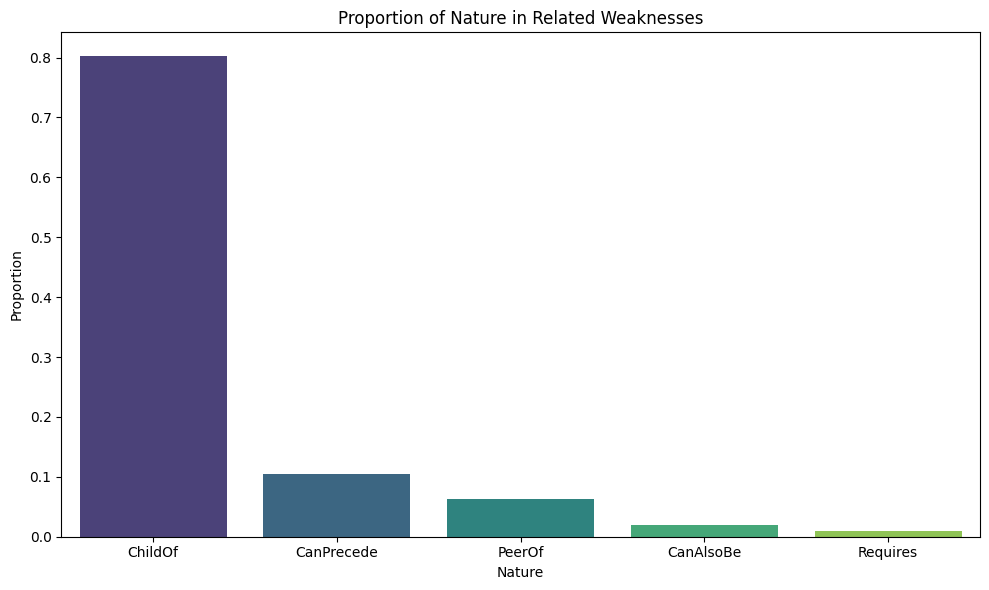

In [172]:
rw_distr = rwn_distribution(jview1000_complete, '1000', True)

,Usage,Count
0,Allowed,752
1,Allowed-with-Review,87
2,Prohibited,59
3,Discouraged,42


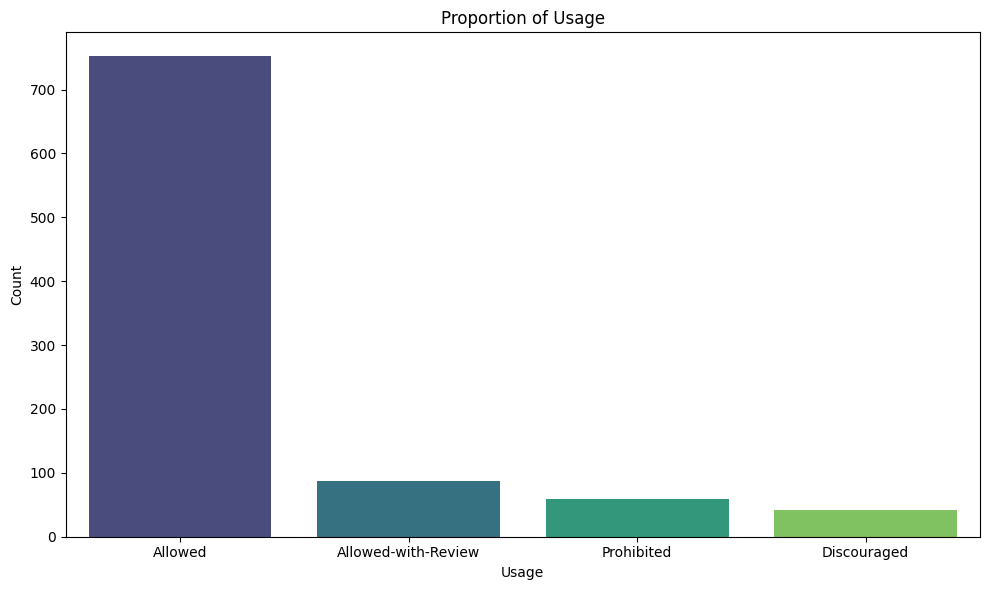

MappingNotes_Usage
Allowed                752
Allowed-with-Review     87
Prohibited              59
Discouraged             42
Name: count, dtype: int64

In [180]:
usage_distribution(jview1000_complete)

In [31]:
view_max_depth(jview1000_complete, '1000')

5